In [10]:
import yfinance            as yf
import pandas              as pd
import numpy               as np
from sklearn.linear_model  import Lasso
from sklearn.model_selection import train_test_split

In [11]:
btc = yf.Ticker("BTC-USD").history(period="30y")

btc_levels = btc['Close'].copy()
btc_levels

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2022-10-02 00:00:00+00:00    19044.107422
2022-10-03 00:00:00+00:00    19623.580078
2022-10-04 00:00:00+00:00    20336.843750
2022-10-05 00:00:00+00:00    20160.716797
2022-10-06 00:00:00+00:00    20056.832031
Name: Close, Length: 2942, dtype: float64

In [12]:
eth = yf.Ticker("ETH-USD").history(period="30y")

eth_levels = btc['Close'].copy()

ldo = yf.Ticker("LDO-USD").history(period="30y")

ldo_levels = btc['Close'].copy()

In [13]:
def sma(data_levels,params = 50):
    
    data = pd.DataFrame(data_levels).copy()
    
    data['SMA_{}'.format(params)]  = data.iloc[:,0].rolling(params).mean()
    data['Returns'] = data.iloc[:,0].pct_change()
    data = data.dropna()

    signals = []

    for i in range(len(data)):
        
        ## if SMA > current price = buy
        if data.iloc[:,0].iloc[i] > data.iloc[:,1].iloc[i]:
            signals.append(1)
        
        # if SMA < current price = sell
        if data.iloc[:,0].iloc[i] < data.iloc[:,1].iloc[i]:
            signals.append(0)
            
        # if SMA == current price = do nothing 
        if data.iloc[:,0].iloc[i] == data.iloc[:,1].iloc[i]:
            print('test')
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

,Close,SMA_50,Returns,Signals
Date,,,,
2014-11-05 00:00:00+00:00,339.485992,372.766840,0.027214,0
2014-11-06 00:00:00+00:00,349.290009,370.605960,0.028879,0
2014-11-07 00:00:00+00:00,342.415009,368.965460,-0.019683,0
2014-11-08 00:00:00+00:00,345.488007,367.979301,0.008974,0
2014-11-09 00:00:00+00:00,363.264008,367.066501,0.051452,0
...,...,...,...,...
2022-10-02 00:00:00+00:00,19044.107422,20419.034141,-0.013877,0
2022-10-03 00:00:00+00:00,19623.580078,20325.119063,0.030428,0
2022-10-04 00:00:00+00:00,20336.843750,20249.116484,0.036347,1


<AxesSubplot:xlabel='Date'>

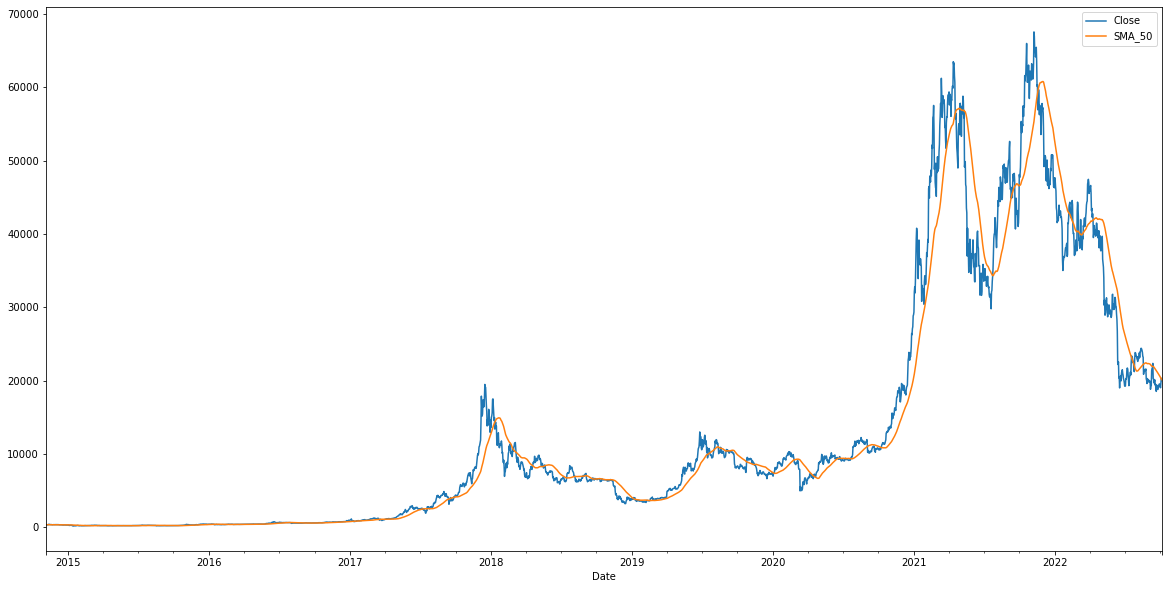

In [14]:
df = sma(btc_levels)

display(df)

df[['Close','SMA_50']].plot(figsize = (20,10))

In [15]:
def backtester(signals,price, tcost = 0.005):

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1

        for i,val in enumerate(price):

            if i == len(price)-1:
                break


            if signals[i] == 0:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
                pos_val[i+1] = 0

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0


        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        return pd.DataFrame(returns, index = price.index)

<AxesSubplot:xlabel='Date'>

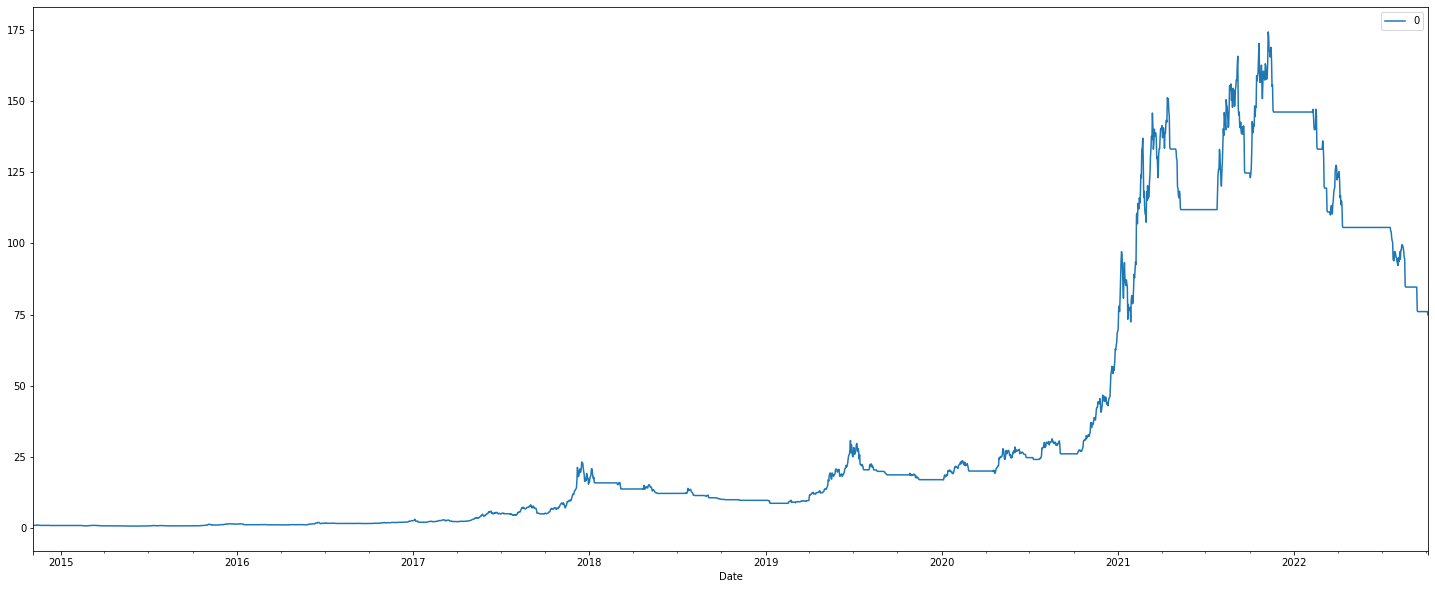

In [16]:
returns = backtester(df['Signals'],df['Close'])
returns.plot(figsize = (25,10))

In [17]:
def win_rate(sigs, returns):
    
    """
    Signals : series
    returns : series
    must be same length
    """
    
    tps = []

    sigs = sigs[1:-1].values.ravel()

    rets = (returns.pct_change()).shift(1).dropna().values.ravel()

    for i,val in enumerate(sigs):

        if (sigs[i] == 1 and rets[i]>0):
            tps.append(1)

    win_rate = sum(tps)/len(sigs)
    return win_rate

win_rate(df['Signals'], returns)

0.31234866828087166

not a good winrate...